In [9]:
import pandas as pd
import numpy as np
from scipy import stats

In [10]:
data = pd.read_csv("treated_data.csv")
target_col = 'chronic_obstructive_pulmonary_disease'

In [11]:
print(f"\nDataset: {data.shape[0]} samples, {data.shape[1]} features")
print(f"COPD classes: {sorted(data[target_col].unique())}")


Dataset: 10000 samples, 17 features
COPD classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


In [12]:
print(data[target_col].value_counts().sort_index())

chronic_obstructive_pulmonary_disease
0    2521
1    2502
2    2524
3    2453
Name: count, dtype: int64


In [13]:
feature_map = {
    'Continuous': ['age', 'bmi', 'medication_count', 'days_hospitalized', 'last_lab_glucose', 'albumin_globulin_ratio'],
    'Binary': ['sex', 'smoker', 'readmitted', 'urban'],
    'Ordinal': ['exercise_frequency', 'diet_quality', 'income_bracket', 'education_level'],
    'Nominal': ['diagnosis_code']
}

excluded = {target_col, 'alanine_aminotransferase'}
numeric_cols = set(data.select_dtypes(include=[np.number]).columns) - excluded

anova_results = []
target_values = sorted(data[target_col].unique())

for category, features in feature_map.items():
    # Filter features that exist in numeric_cols
    valid_features = [f for f in features if f in numeric_cols]
    
    if not valid_features:
        continue

    print(f"\n{category} Features:")
    for feature in valid_features:
        # Group data and run ANOVA
        groups = [data[data[target_col] == c][feature].dropna() for c in target_values]
        f_stat, p_value = stats.f_oneway(*groups)
        significant = p_value < 0.05
        
        res = {
            'Feature': feature,
            'Type': category,
            'F-statistic': f_stat,
            'p-value': p_value,
            'Significant': 'Y' if significant else 'N'
        }
        anova_results.append(res)
        
        print(f"  {feature:30s} F={f_stat:7.3f}, p={p_value:.4f} {res['Significant']}")

anova_df = pd.DataFrame(anova_results)
num_significant = (anova_df['p-value'] < 0.05).sum()
print(f"\n{num_significant}/{len(anova_results)} features significant (p < 0.05)")


Continuous Features:
  age                            F=  0.589, p=0.6221 N
  bmi                            F=  0.209, p=0.8901 N
  medication_count               F=  0.563, p=0.6395 N
  days_hospitalized              F=  0.492, p=0.6881 N
  last_lab_glucose               F=  1.663, p=0.1726 N
  albumin_globulin_ratio         F=  0.999, p=0.3920 N

Binary Features:
  sex                            F=  0.471, p=0.7027 N
  smoker                         F=  0.403, p=0.7507 N
  readmitted                     F=  0.420, p=0.7387 N
  urban                          F=  0.154, p=0.9269 N

Ordinal Features:
  exercise_frequency             F=  3.624, p=0.0125 Y
  diet_quality                   F=  1.189, p=0.3122 N
  income_bracket                 F=  0.851, p=0.4659 N
  education_level                F=  1.689, p=0.1670 N

Nominal Features:
  diagnosis_code                 F=  1.528, p=0.2051 N

1/15 features significant (p < 0.05)


With the above anova test we can see that only one variable of 15 has a significant effect on the outcome of the chronic_obstructive_pulmonary_disease

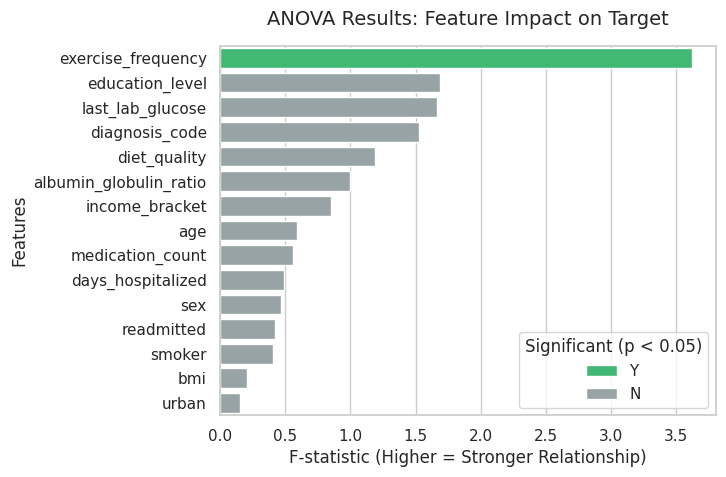

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_data = anova_df.sort_values('F-statistic', ascending=False)

sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=plot_data, 
    x='F-statistic', 
    y='Feature', 
    hue='Significant', 
    palette={'Y': '#2ecc71', 'N': '#95a5a6'},
    dodge=False
)

plt.title('ANOVA Results: Feature Impact on Target', fontsize=14, pad=15)
plt.xlabel('F-statistic (Higher = Stronger Relationship)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(title='Significant (p < 0.05)', loc='lower right')

plt.savefig('anova_f_stats.png', bbox_inches='tight')

After we found out that only exercise_frequency has an effect on chronic_obstructive_pulmonary_disease we could build a model that only takes that in account.

In [15]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [16]:
print(data.groupby(target_col)['exercise_frequency'].mean())
print("\nOverall exercise frequency distribution:")
print(data['exercise_frequency'].value_counts(dropna=False).sort_index())

chronic_obstructive_pulmonary_disease
0    0.891045
1    0.894394
2    0.867261
3    0.822540
Name: exercise_frequency, dtype: float64

Overall exercise frequency distribution:
exercise_frequency
0.0    2983
1.0    3068
2.0    1937
NaN    2012
Name: count, dtype: int64


In [17]:
X_single = data[['exercise_frequency']]
y = data[target_col]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_single = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    random_state=42,
    eval_metric='mlogloss'
)

scores_single = cross_val_score(
    model_single, X_single, y,
    cv=cv, scoring='accuracy', n_jobs=-1
)

print(f"\nAccuracy: {scores_single.mean():.4f} ± {scores_single.std():.4f}")


Accuracy: 0.2463 ± 0.0060


In [18]:
#compare all features vs exercise_frequency alone
X_all = data.drop([target_col, 'alanine_aminotransferase'], axis=1)

scores_all = cross_val_score(
    xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42),
    X_all, y,
    cv=cv, scoring='accuracy', n_jobs=-1
)

print(f"{'Model':<30} {'Accuracy':<15}")
print("-"*70)
print(f"{'All features':<30} {scores_all.mean():.4f} ± {scores_all.std():.4f} ")
print(f"{'exercise_frequency only':<30} {scores_single.mean():.4f} ± {scores_single.std():.4f}")
print(f"{'Random baseline':<30} 0.2500")

Model                          Accuracy       
----------------------------------------------------------------------
All features                   0.2478 ± 0.0112 
exercise_frequency only        0.2463 ± 0.0060
Random baseline                0.2500


Even when using exercise_frequency, the only variable with a significant p-value, the model produced poor results. Therefore, this dataset does not allow for an accurate prediction of chronic obstructive pulmonary disease.